In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
from jax.experimental import optix
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
from jax_lensing.inversion import ks93inv

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

#from jax_lensing.models.convdae import UResNet, SmallUResNet
from jax_lensing.inversion import ks93inv, ks93
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
dataset = "kappatng"
#weight_dir = "../weights/gp-no_sn"
weight_dir = "../weights/gp-sn1v2"
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2

In [5]:
rng_seq = hk.PRNGSequence(42)

In [6]:
def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [7]:
# import trained model weights
#model_name = "model-35000.pckl"
model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [8]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

  # If the Gaussian prior is used, load the theoretical power spectrum
if gaussian_prior:
    ps_data = onp.load(gaussian_path).astype('float32')
    ell = jnp.array(ps_data[0,:])
    # massivenu: channel 4
    ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
    # convert to pixel units of our simple power spectrum calculator
    kell = ell / (360/3.5/0.5) / float(map_size)
    # Interpolate the Power Spectrum in Fourier Space
    power_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))
    
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

score_fn = partial(score_fn, params, state, next(rng_seq))

In [9]:
train_set = load_dataset(dataset,
                             batch_size,
                             map_size,
                             noise_dist_std,
                             train_split)

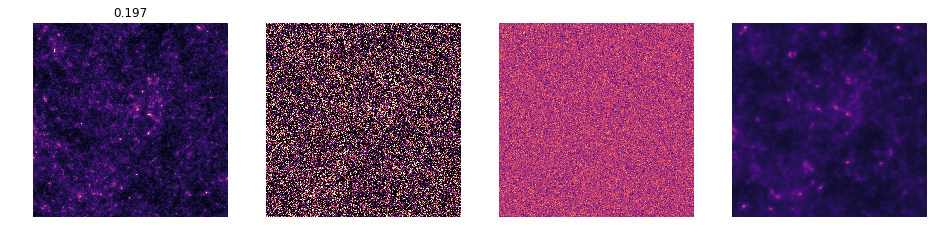

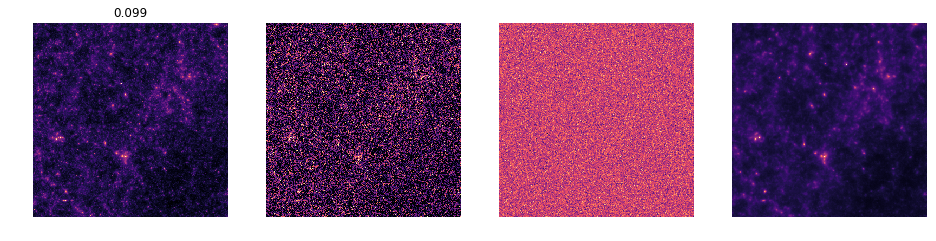

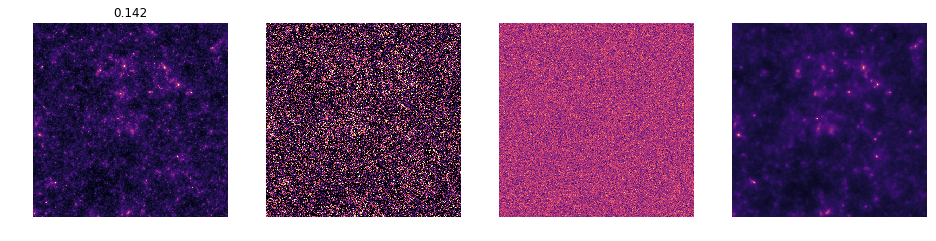

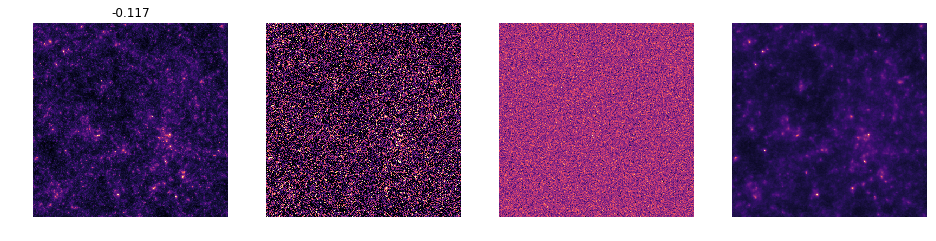

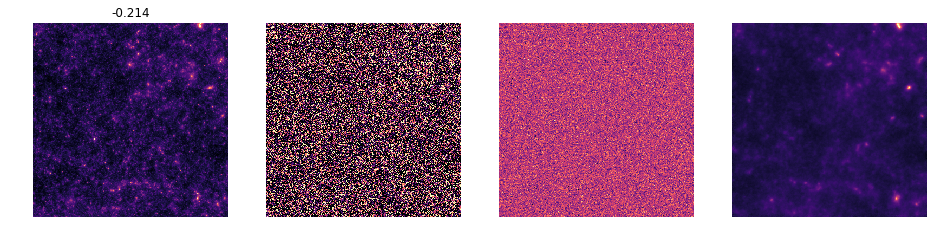

In [10]:
batch = next(train_set)
#res, state = score_fn(batch['x'],batch['s'], is_training=False)
_, res, gaussian_score = score_fn(batch)

for i in range(5):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    #imshow(res[ind,...,0],cmap='magma')
    imshow(res[ind,...,0] + gaussian_score[ind,...,0], cmap='magma')
    axis('off')
    #title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
    subplot(144)
    #imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    #batch['s'] * (res + gaussian_score))**2
    axis('off')

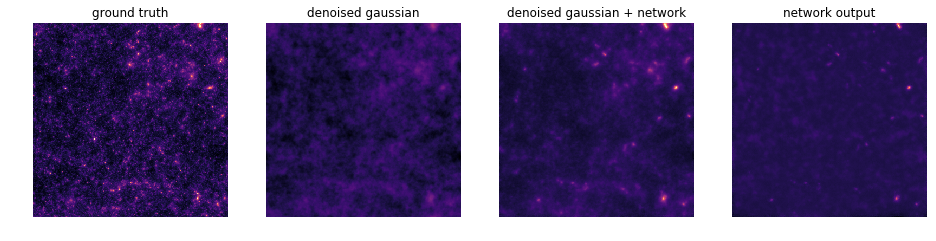

In [11]:
figure(figsize=(16,4))



subplot(141)

imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
title('ground truth')
#colorbar()
axis('off')

subplot(142)

imshow(batch['y'][ind,...,0] + (batch['s'][ind,:,:,0]**2) *(gaussian_score[ind,...,0]), cmap='magma', vmin=-0.05,vmax=0.3)
title('denoised gaussian')
axis('off')
#colorbar()

subplot(143)

imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
title('denoised gaussian + network')
axis('off')
#title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
#colorbar()

subplot(144)

imshow((batch['s'][ind,:,:,0]**2) * res[ind,...,0], cmap='magma',vmin=-0.05,vmax=0.3)
title('network output')
axis('off')

#batch['s'] * (res + gaussian_score))**2
#colorbar()
savefig('gauss-res.png')

[[0.19682354]]


(-0.5, 359.5, 359.5, -0.5)

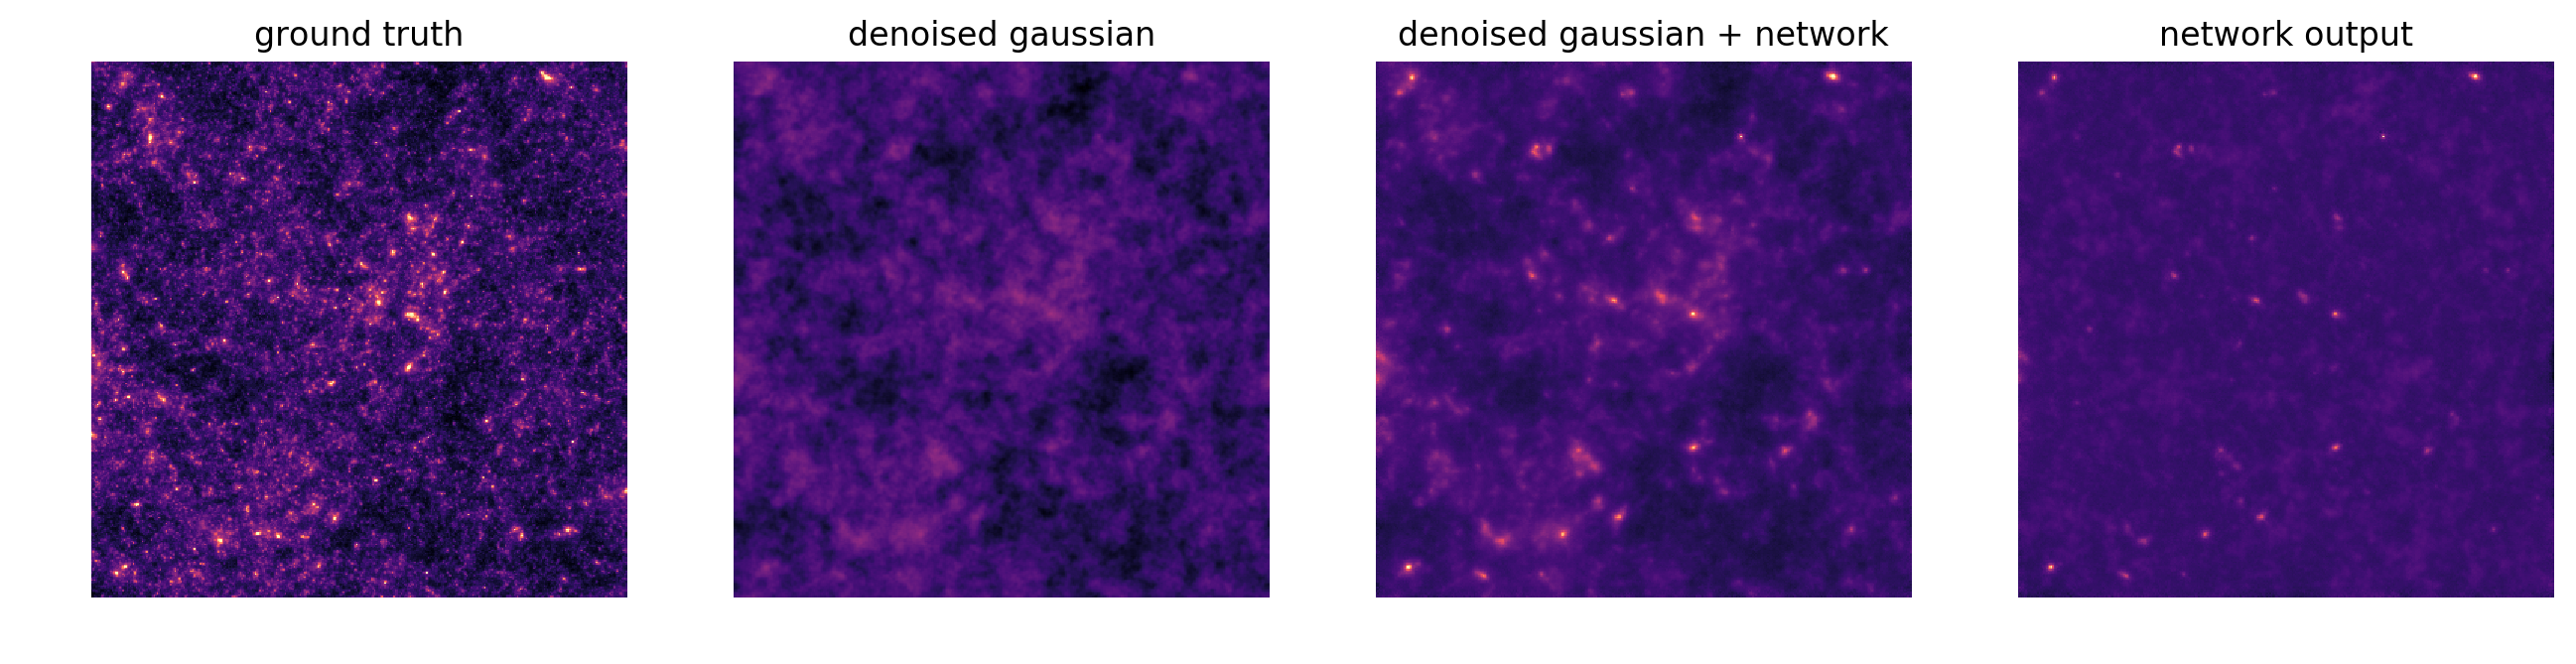

In [12]:
figure(figsize=(16,4), dpi=200)

ind = 0

print(batch['s'][ind,:,:,0])
#style.use('dark_background')
vmax = 0.2

subplot(141)

imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=vmax)
title('ground truth')
#colorbar()
axis('off')

subplot(142)

imshow(batch['y'][ind,...,0] + (batch['s'][ind,:,:,0]**2) *(gaussian_score[ind,...,0]), cmap='magma', vmin=-0.05,vmax=vmax)
title('denoised gaussian')
axis('off')
#colorbar()

subplot(143)

imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=vmax)
title('denoised gaussian + network')
axis('off')
#title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
#colorbar()

subplot(144)

imshow((batch['s'][ind,:,:,0]**2) * res[ind,...,0], cmap='magma',vmin=-0.05,vmax=vmax)
title('network output')
axis('off')

#savefig('gauss-res.png')

In [13]:
batch['s'][ind,:,:,0]

array([[0.19682354]], dtype=float32)

## MAP

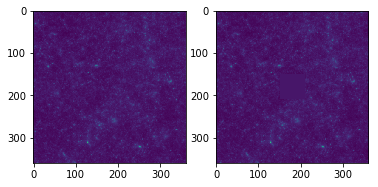

In [14]:
batch = next(train_set)
x = batch['x']
mask = np.ones_like(x[0:1])
mask[:, 150:210, 150:210] = 0
x_masked = np.copy(x[0:1]) * mask
subplot(121)
imshow(x[0,...,0])
subplot(122)
imshow(x_masked[0,...,0])

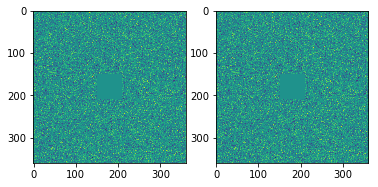

In [15]:
# Shear
mask = mask.reshape((360,360))

kE = x[0,...,0]
kB = jnp.zeros_like(kE)
g1, g2 = ks93inv(kE, kB)

shear_noise = 0.14849374 # per pixel
g1 = g1 + onp.random.randn(map_size, map_size) * shear_noise
g2 = g2 + onp.random.randn(map_size, map_size) * shear_noise

masked_g1 = g1 * mask
masked_g2 = g2 * mask

subplot(121)
imshow(masked_g1)
subplot(122)
imshow(masked_g1)

true_shear = jnp.stack([masked_g1, masked_g2], axis=0).flatten()

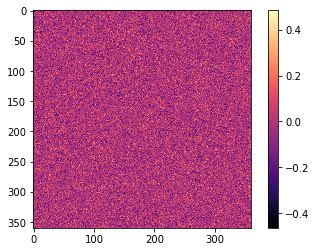

In [16]:
temp = 1e-2
sigma = jnp.ones((1,1)) * temp

init_image=(0.1*randn(1,360,360)).reshape((-1, 360*360)).astype('float32')

imshow(init_image.reshape((360,360)), cmap='magma')
colorbar()

In [17]:
#kappa_init, _ = ks93(masked_g1, masked_g2)
#imshow(kappa_init)
#colorbar()

#init_image = kappa_init.reshape(1, 360*360)

In [18]:
# likelihood score
mask_shear = jnp.stack([mask, mask], axis=0).flatten()

def likelihood_fn(x, sigma):
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros_like(ke)
    gamma1, gamma2 = ks93inv(ke, kb)
    masked_gamma1, masked_gamma2 = (mask.reshape((map_size, map_size))*gamma1,
                                    gamma2*mask.reshape((map_size, map_size)))
    shear = jnp.stack([masked_gamma1, masked_gamma2], axis=0).flatten()
    #return jnp.sum( ((shear-true_shear)/(1e-2 + sigma))**2 )/2.
    return jnp.sum( mask_shear*(shear-true_shear)**2/((shear_noise)**2 + sigma**2))/2.

score_likelihood = jax.vmap(jax.grad(likelihood_fn))

In [19]:
score_likelihood(init_image, sigma).shape

(1, 129600)

In [20]:
net_input = {'y':init_image.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
_, res, gaussian_score = score_fn(net_input)
print((res[..., 0:1] + gaussian_score).shape)

(1, 360, 360, 1)


In [21]:
score_lh = score_likelihood(init_image, sigma).reshape(1, 360, 360, 1)

net_input = {'y':init_image.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
_, res, gaussian_score = score_fn(net_input)
score_p = res[..., 0:1] + gaussian_score

(-score_lh + score_p).shape

(1, 360, 360, 1)

In [34]:
eps = 1e-7

n_steps = 5000
temp_init = 1e-1
temp_final = 1e-2

temp_list = jnp.arange(temp_init, temp_final, step=(temp_final-temp_init)/n_steps)

@jax.jit
def update(x_old, temp):
    # prior score
    sigma = np.ones(1) * temp

    net_input = {'y':x_old.reshape(1,360, 360,1), 's':sigma.reshape(1,1,1,1)}
    _, res, gaussian_score = score_fn(net_input)
    score_p = (res[..., 0:1] + gaussian_score)
    # likelihood score
    score_lh = score_likelihood(x_old, sigma).reshape(1, 360, 360, 1)
    
    score_post = - score_lh + score_p
    
    x_new = x_old + eps*(temp/temp_final)**2 * score_post.reshape(-1, 360*360)
    return x_new

#x_new = update(init_image)

In [35]:
x_old = init_image.copy()
loss = []
samples = []

for i in range(n_steps):
    temp = temp_list[i]
    x_new = update(x_old, temp)
    l = jnp.mean(jnp.linalg.norm(x[0,...,0].reshape(360, 360) - x_new.reshape(360, 360)))
    loss.append(l)
    samples.append(x_new)
    x_old = x_new

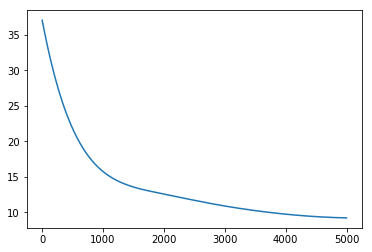

In [36]:
plot(loss)

Text(0.5,1,'MAP')

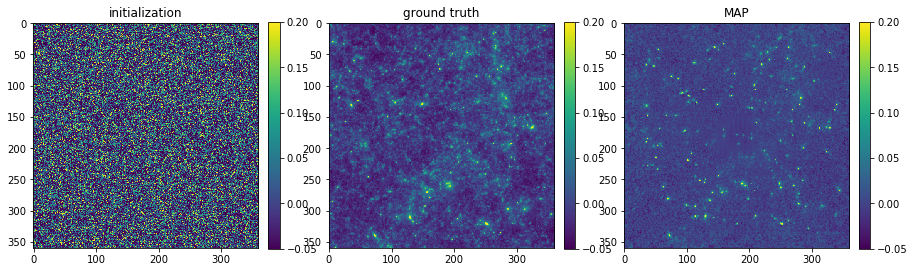

In [37]:
figure(figsize=(15,5))

vmax = 0.2

subplot(131)
imshow(init_image.reshape(360, 360), vmin=-0.05,vmax=vmax)
colorbar(fraction=0.046, pad=0.04)
title('initialization')

subplot(132)
imshow(x[0,...,0].reshape(360, 360), vmin=-0.05,vmax=vmax)
colorbar(fraction=0.046, pad=0.04)
title('ground truth')

subplot(133)
imshow(x_new.reshape(360, 360), vmin=-0.05,vmax=vmax)
colorbar(fraction=0.046, pad=0.04)
title('MAP')

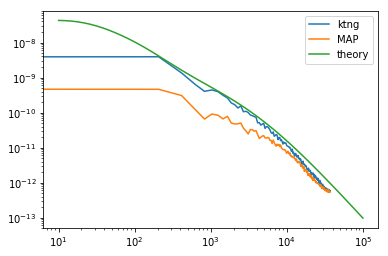

In [38]:
resolution_ktng = 0.29 # pixel resolution: 0.29 arcmin/pixel
pixel_size_ktng = np.pi * resolution_ktng / 180. / 60. #rad/pixel

ell_true, ps_true = measure_power_spectrum(x[0,...,0].reshape(360,360), pixel_size_ktng)
ell_map, ps_map = measure_power_spectrum(x_new.reshape(360,360), pixel_size_ktng)

ps_data = onp.load(gaussian_path).astype('float32')

loglog(ell_true, ps_true, label='ktng')
loglog(ell_map, ps_map, label='MAP')
loglog(ps_data[0,:], ps_data[1,:], label='theory')
legend()

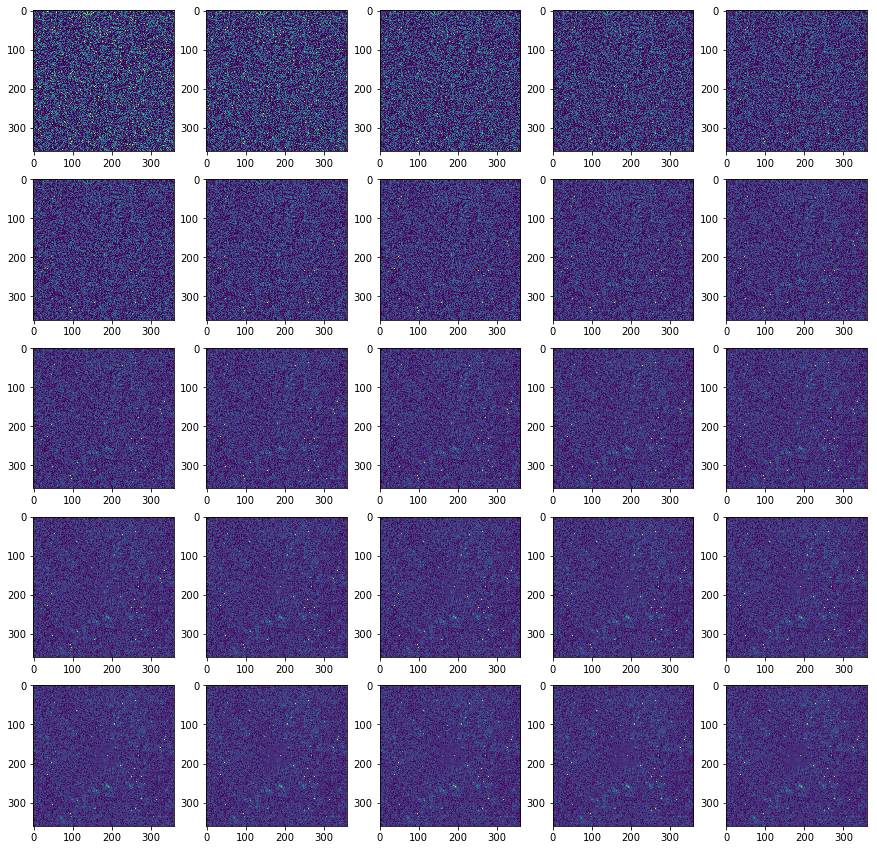

In [33]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5,5,i*5+j+1)
        imshow(samples[(i*5+j)*100].reshape(360, 360), vmin=-0.05,vmax=0.3)

**Using an optimizer**